### The German Traffic Sign Benchmark

Student Name 1: ...

Student Name 2: ...

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [0]:
# !wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
# !unzip FullIJCNN2013.zip

In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (32, 32)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

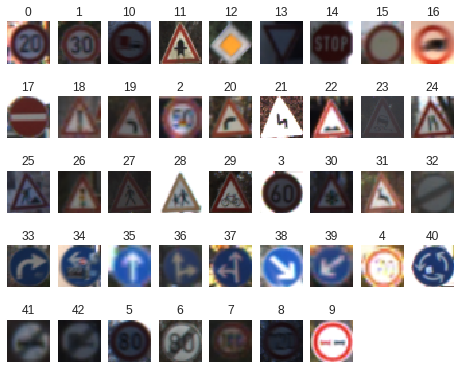

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.2: Convolutional Neural Network

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU, BatchNormalization, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam, SGD

act = LeakyReLU(alpha=0.2)

cnn = Sequential()
# convolutional 1st layers
cnn.add(Conv2D(filters=32, strides=(1, 1), kernel_size=(3, 3), padding='same', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))

cnn.add(Activation(act))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))

# conv 2nd layer
cnn.add(Conv2D(filters=32, strides=(1, 1), kernel_size=(3, 3), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D(pool_size=(2, 2))) # downscale

# conv 3rd layer
cnn.add(Conv2D(filters=64, strides=(1, 1), kernel_size=(3, 3), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))
cnn.add(Dropout(0.2))

# conv 4th layer
cnn.add(Conv2D(filters=64, strides=(1, 1), kernel_size=(3, 3), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D(pool_size=(2, 2))) # downscale

# conv 5th layer
cnn.add(Conv2D(filters=128, strides=(1, 1), kernel_size=(3, 3), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))
cnn.add(Dropout(0.2))

# conv 6th layer
cnn.add(Conv2D(filters=128, strides=(1, 1), kernel_size=(3, 3), padding='same'))
cnn.add(BatchNormalization())
cnn.add(Activation(act))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D(pool_size=(2, 2))) # downscale

# dense layers
cnn.add(Flatten())
cnn.add(Dense(512))
cnn.add(BatchNormalization())
cnn.add(Activation(act))
cnn.add(Dropout(0.2))

cnn.add(Dense(num_classes))
cnn.add(Activation('softmax'))

#opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
lr = 0.01
opt = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
___________________________

In [8]:
data = cnn.fit(tr_signs, tr_labels, batch_size=16, epochs=30, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Instructions for updating:
Use tf.cast instead.
Train on 600 samples, validate on 252 samples
Epoch 1/30
 - 4s - loss: 3.4620 - acc: 0.1767 - val_loss: 3.4072 - val_acc: 0.2579
Epoch 2/30
 - 1s - loss: 2.3599 - acc: 0.3767 - val_loss: 2.4194 - val_acc: 0.3095
Epoch 3/30
 - 1s - loss: 1.7209 - acc: 0.5017 - val_loss: 1.7193 - val_acc: 0.4881
Epoch 4/30
 - 1s - loss: 1.0914 - acc: 0.6733 - val_loss: 1.8716 - val_acc: 0.5040
Epoch 5/30
 - 1s - loss: 0.7675 - acc: 0.7567 - val_loss: 1.5969 - val_acc: 0.5317
Epoch 6/30
 - 1s - loss: 0.5026 - acc: 0.8417 - val_loss: 1.0504 - val_acc: 0.6468
Epoch 7/30
 - 1s - loss: 0.3733 - acc: 0.8833 - val_loss: 0.7788 - val_acc: 0.7262
Epoch 8/30
 - 1s - loss: 0.2509 - acc: 0.9150 - val_loss: 0.7817 - val_acc: 0.7579
Epoch 9/30
 - 1s - loss: 0.2200 - acc: 0.9383 - val_loss: 0.8065 - val_acc: 0.7698
Epoch 10/30
 - 1s - loss: 0.1727 - acc: 0.9517 - val_loss: 0.7220 - val_acc: 0.7897
Epoch 11/30
 - 1s - loss: 0.1604 - acc: 0.9500 - val_loss: 0.5865 - val_acc

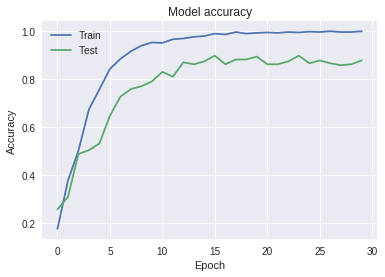

In [9]:
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

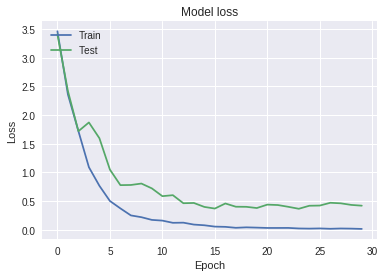

In [10]:
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

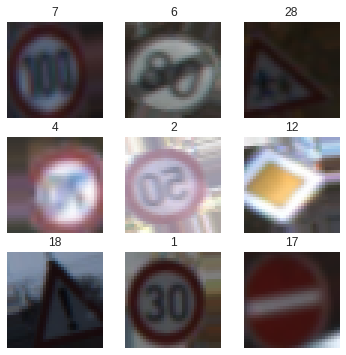

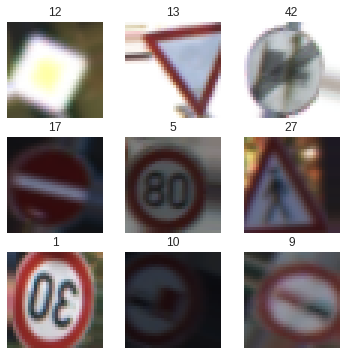

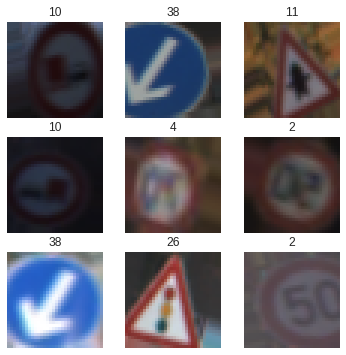

In [11]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=25, width_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
datagen.fit(tr_signs, augment=True)

j=0
for x_batch, y_batch in datagen.flow(tr_signs, tr_labels, batch_size=9):
    j+=1
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
    # show the plot
    plt.show()
    if j %3 ==0:
      break



In [12]:
train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)
data = cnn.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=16), epochs=250, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=[tensorboard])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Epoch 1/250
 - 1s - loss: 2.2747 - acc: 0.4814 - val_loss: 1.8189 - val_acc: 0.5913
Epoch 2/250
 - 1s - loss: 1.5782 - acc: 0.5439 - val_loss: 1.1841 - val_acc: 0.6825
Epoch 3/250
 - 1s - loss: 1.1931 - acc: 0.6706 - val_loss: 0.9266 - val_acc: 0.7500
Epoch 4/250
 - 1s - loss: 1.0649 - acc: 0.6572 - val_loss: 0.9537 - val_acc: 0.7183
Epoch 5/250
 - 1s - loss: 1.0541 - acc: 0.6571 - val_loss: 0.9767 - val_acc: 0.7143
Epoch 6/250
 - 1s - loss: 1.0181 - acc: 0.6538 - val_loss: 1.0136 - val_acc: 0.7143
Epoch 7/250
 - 1s - loss: 0.9935 - acc: 0.6927 - val_loss: 0.7212 - val_acc: 0.8413
Epoch 8/250
 - 1s - loss: 0.9040 - acc: 0.7263 - val_loss: 0.8500 - val_acc: 0.7698
Epoch 9/250
 - 1s - loss: 0.7842 - acc: 0.7568 - val_loss: 0.6687 - val_acc: 0.7937
Epoch 10/250
 - 1s - loss: 0.7368 - acc: 0.7584 - val_loss: 0.6678 - val_acc: 0.7937
Epoch 11/250
 - 1s - loss: 0.6748 - acc: 0.7770 - val_loss: 0.6193 - val_acc: 0.7937
Epoch 12/250
 - 1s - loss: 0.6870 - acc: 0.7702 - val_loss: 0.7006 - val_a

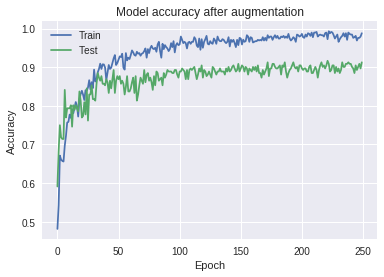

In [13]:
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy after augmentation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

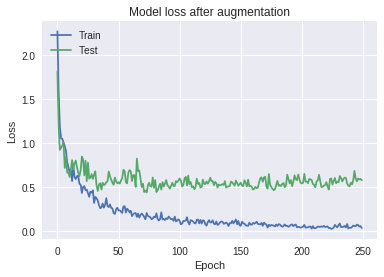

In [14]:
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss after augmentation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()